# Laboratorium

### Konfiguracja

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
from matplotlib.patches import Arc
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15


def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))


# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []
        self.autoscale = True

    def set_axes(self, ax):
        self.ax = ax

    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling=self.autoscale)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling=self.autoscale)

    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))

    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.
    def add_line(self, event):
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()

    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []

    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling=False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling=False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling=False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (
                        np.mean([self.ax.get_xlim(), self.ax.get_ylim()]) * TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling=False)

    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling=True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()

        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())

        for circle in self.scenes[self.i].circles:
            self.ax.add_patch(circle)

        if autoscaling:
            self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()

### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [2]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[], circles=[]):
        self.points = points
        self.lines = lines
        self.circles = circles


# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs

    def add_points(self, points):
        self.points = self.points + points


# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs

    def add(self, line):
        self.lines.append(line)

    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)


# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes=[Scene()], points=[], lines=[], json=None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]],
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]])
                           for scene in js.loads(json)]

    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]

    def add_scene(self, scene):
        self.scenes.append(scene)

    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points],
                          "lines": [linesCol.lines for linesCol in scene.lines]}
                         for scene in self.scenes])

        # Metoda ta zwraca punkty dodane w trakcie rysowania.

    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None

    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None

    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None

    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines + self.callback.added_rects)
        else:
            return None

    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self, scale=True):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()

        ax = plt.axes(autoscale_on=False)
        if scale is False:
            ax.set(xlim=plt.xlim, ylim=plt.ylim)
        self.callback.set_axes(ax)
        self.callback.autoscale = scale
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw(scale)

### Przykłady użycia

##### Proste rysowanie

Rysowanie prostego rysunku złożonego ze statycznych punktów i odcinków jest stosunkowo proste. Należy utworzyć zmienną z obiektem `Plot`, który przyjmuje w konstruktorze listę obiektów `PointsCollection` jako parametr `points` oraz listę `LinesCollection` jako parametr `lines`. Następnie należy wywołać jego metodę `draw()`.

<IPython.core.display.Javascript object>


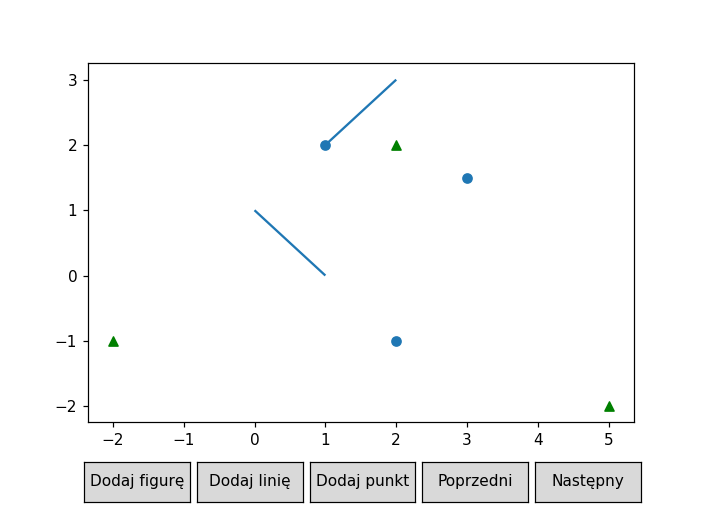

In [3]:
%matplotlib notebook

plot = Plot(points=[PointsCollection([(1, 2), (3, 1.5), (2, -1)]),
               PointsCollection([(5, -2), (2, 2), (-2, -1)], color='green', marker = "^")],
            lines=[LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])])
plot.draw()

##### Rysunek dynamiczny

To narzędzie pozwala na wizualizację "rysunków dynamicznych", a więc takich, które składają się z wielu różnych obrazów. Może to być przydatne np. podczas wizualizacji kolejnych kroków danego algorytmu. Poszczególne klatki określane są jako obiekty `Scene`, które przyjmują listę `PointsCollection` oraz listę `LinesCollection` w swoim konstruktorze. Obiekt `Plot` przyjmuje w parametrze konstruktora `scenes` właśnie listę takich scen.

Na rysunku przyciski `Następny` i `Poprzedni` służą do nawigacji pomiędzy nimi.

<IPython.core.display.Javascript object>


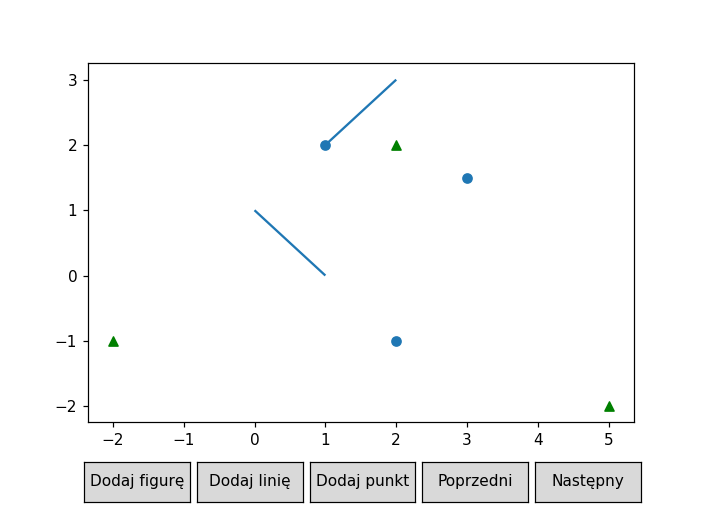

In [4]:
%matplotlib notebook

scenes=[Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)]), 
               PointsCollection([(5, -2), (2, 2), (-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)], color='red'), 
               PointsCollection([(5, -2), (2, 2), (-2, 1)], color='black')], 
              [LinesCollection([[(-1,2),(-2,3)], [(0,-1),(-1,0)]])])]

plot=Plot(scenes = scenes)
plot.draw() 


###### Zapis i odczyt z pliku

Klasa Plot posiada metodę `toJson()`, która zwraca string zawierający listę scen w formacie JSON. Taki string można normalnie zapisać do pliku stosując normalne sposoby dostępne w Pythonie. Wczytanie listy scen z pliku dokonuje się poprzez podanie parametru `json` w kostruktorze `Plot`.

<IPython.core.display.Javascript object>


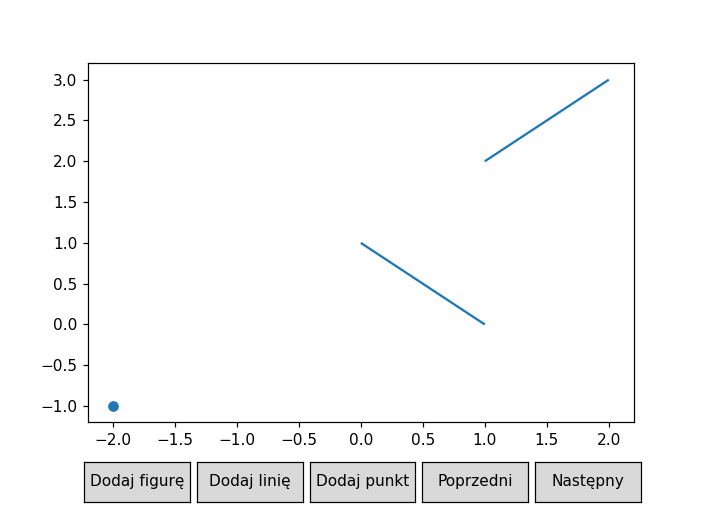

In [5]:
scenes=[Scene([PointsCollection([(-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5)], color='red'), 
               PointsCollection([(5, -2)], color='black')])]
plot = Plot(scenes)

with open('somefile.json', 'w') as file:
    file.write(plot.toJson())
    
#somefile.json: [{"points": [[[-2, -1]]], "lines": [[[[1, 2], [2, 3]], [[0, 1], [1, 0]]]]}, {"points": [[[1.0, 2.0], [3.0, 1.5]], [[5, -2]]], "lines": []}]
    
with open('somefile.json', 'r') as file:
    json = file.read()
    
plot2 = Plot(json=json)
plot2.draw()

### Rozwiązanie

In [6]:
import random
import math
import numpy as np
from matplotlib import path
from matplotlib.patches import Arc

In [7]:
def generate_points(n,interval):
    a = interval[0]
    b= interval[1]
    from random import randint
    set_a = [(random.uniform(a,b),random.uniform(a,b)) for _ in range(n)]
    return set_a

In [8]:
def det(a,b,c):
    return a[0]*b[1] + b[0]*c[1] + a[1]*c[0] - c[0]*b[1] - b[0]*a[1] - a[0]*c[1]

In [9]:
# sprawdza, czy punkt leży wewnątrz trójkąta

def point_inside(p,t):
    e = 10**-12
    det1 = det(t[0],t[1],p)
    det2 = det(t[1],t[2],p)
    det3 = det(t[2],t[0],p)

    return (det1>e and det2>e and det3>e) or (det1<-e and det2<-e and det3<-e)

In [10]:
# sprawdza, czy trójkąty sa takie same

def equals(t1, t2):
    if t1 is None and t2 is None:
        return True
    if t1 is not None and t2 is not None:
        if t1[0] == t2[0] and t1[1] == t2[1] and t1[2] == t2[2] :
            return True
            
    return False

In [11]:
# trójkąt jest "pusty" - nie bierzemy go pod uwagę

def is_empty(t):
    return t == None or (t[0] == None and t[1] == None and t[2] == None)

In [12]:
# środek ciężkości trójkąta

def triangle_center(t):
    return ((t[0][0]+t[1][0]+t[2][0])/3, (t[0][1]+t[1][1]+t[2][1])/3)


# wersor - wektor jednostkowy, określa kierunek i zwrot wektora danego 2 punktami

def unit_vector(p1, p2):
    v = (p2[0]-p1[0], p2[1]-p1[1])
    
    norm = np.linalg.norm(v)
    
    if abs(norm) < 10**-9:
        return v
    else:
        return v / norm


In [13]:
# odnajduje pierwszy "niepusty" trójkąt aktualnej triangulacji

def first_triangle(triangles):
    for t in triangles:
        if not is_empty(t):
            return t

In [14]:
# sprawdza, czy dany trójkąt był juz odwiedzony

def has_been_visited(t, visited):
    if t == None: return True
    for v in visited:
        if equals(t,v): return True 
    return False

In [41]:
# odszukuje trójkąt zawierający dany punkt, zaczynając od pierwszego trójkąta triangulacji,
# idąc po kolejnych sąsiadach
    
def find_triangle(point, triangles):
    
    def find_triangle_recursive(p, t, last):
        
        idx = 0
        ctr = 0
        visited = []

        while True:
            up = False
            ctr += 1
            
            # znaleziono trójkąt zawierający punkt
            if not is_empty(t) and point_inside(p, t):
                return t

            d1 = float("inf")
            d2 = float("inf")
            
            # sąsiednie trójkąty
            ngh1 = t[3]
            ngh2 = t[4]
            ngh3 = t[5]

            if equals(ngh1, last):
                next1 = ngh2
                next2 = ngh3
                
            elif equals(ngh2, last):
                next1 = ngh1
                next2 = ngh3
                
            else:
                next1 = ngh1
                next2 = ngh2

            visited1 = has_been_visited(next1, visited)
            visited2 = has_been_visited(next2, visited)

            if not has_been_visited(t, visited):
                visited.append(t)

            if next1 == None and next2 is not None:
                if not visited2:
                    t = next2
                    continue
                else:
                    up = True

            if next2 == None and next1 is not None:
                if not visited1:
                    t = next1
                    continue
                else:
                    up = True

            if not up and not is_empty(t):
                center   = triangle_center(t)
                c1   = triangle_center(next1)
                c2   = triangle_center(next2)
                u1 = unit_vector(center, c1)
                u2 = unit_vector(center, c2)
                u3 = unit_vector(center, p)
                dot1 = np.dot(u3, u1)
                dot2 = np.dot(u3, u2)

                if dot1 > dot2 and not visited1:
                    last = t
                    t = next1
                    continue

                if dot2 > dot1 and not visited2:
                    last = t
                    t = next2
                    continue

                if not visited1:
                    last = t
                    t = next1
                    continue

                if not visited2:
                    last = t
                    t = next2
                    continue

            last = t
            idx -= 1
            if idx <= 0:
                idx = len(visited)-1
            t = visited[idx]

    first = first_triangle(triangles)
    t = find_triangle_recursive(point, first, None)
    return t


In [16]:
def remove_triangle(triangle):

    # usuwamy każdemu z sąsiadów usuwany trójkąt z listy sąsiadów
    for ngh in triangle[3:6]:
        change_ngh(triangle, None, ngh)
        
    for i in range(6):
        triangle[i] = None

        
def point_on_line(p, t):
    if on_edge(p, t[0], t[1]):
        return 2
    
    if on_edge(p, t[2], t[0]):
        return 1
    
    if on_edge(p, t[1], t[2]):
        return 0
    
    return None


# https://en.wikipedia.org/wiki/Delaunay_triangulation
def legal(t, p):
    p1 = t[0]
    p2 = t[1]
    p3 = t[2]
    matrix = np.array(
            [[p1[0],p1[1],p1[0]**2+p1[1]**2,1],
             [p2[0],p2[1],p2[0]**2+p2[1]**2,1],
             [p3[0],p3[1],p3[0]**2+p3[1]**2,1],
             [p[0],p[1],p[0]**2+p[1]**2,1]])

    return np.linalg.det(matrix) <= 0

# sprawdza, czy dane 2 punkty są wierzchołkami trójkąta

def triangle_vertices(p1, p2, t):
    if t is None:
        return False
    return (p1 == t[0] or p1 == t[1] or p1 == t[2]) and (p2 == t[0] or p2 == t[1] or p2 == t[2])


# zwraca sąsiada trójkąta względem krawędzi p1p2

def get_ngh(p1, p2, t):
    for i in range(3):
        if triangle_vertices(p1, p2, t[3+i]):
            return t[3+i]

    return None

In [17]:
# zwraca 3 punkt trójkąta, gdy mamy dane 2 pozostałe

def get_third_point(triangle,p1,p2):
    for i,p in enumerate(triangle):
        if p != p1 and p != p2:
            return p

In [18]:
# sprawdza czy punkt leży na odcinku (danym 2 punktami) - suma odległości punktu od 
# punktów końcowych odcinka musi być równa odległości końców (z dokładnością do eps)

def on_edge(p, p1, p2, eps = 10**-9):
    dist1 = dist(p, p1)
    dist2 = dist(p, p2)
    dist3 = dist(p1,p2)
    return abs((dist1 + dist2) - dist3) < eps

In [19]:
def legalize(triangles, t, visualize,leg):
     
    nextT = get_ngh(t[1], t[2], t)

    if nextT == None:
        return triangles

    p = get_third_point(nextT,t[1],t[2])
        
    if not legal(t, p):
        # zamieniamy krawędź nielegalną, aktualizujemy sąsiadów     
        t1 = [t[0], t[1], p, get_ngh(t[0], t[1], t), get_ngh(t[1], p, nextT)]
        t2 = [t[0], p, t[2], get_ngh(t[0], t[2], t), get_ngh(t[2], p, nextT), t1]
        

        # można tu dodać wyświetlanie okregów, ale zaciemnia wykres : /
        if visualize:
            lines = [[t[0],t[2]],[t[0],t[1]],[p,t[2]],[p,t[1]]]
            leg.append(([t[1],t[2]],[t[0],p],lines))
        
        t1.append(t2)

        change_ngh(t, t1, t1[3])
        change_ngh(nextT, t1, t1[4])

        change_ngh(t, t2, t2[3])
        change_ngh(nextT, t2, t2[4])

        remove_triangle(t)
        remove_triangle(nextT)

        triangles.append(t1)
        triangles.append(t2)

        triangles = legalize(triangles, t1, visualize,leg)
        triangles = legalize(triangles, t2, visualize,leg)
        
    return triangles

In [20]:
def change_ngh(fromT, toT, t):
    for i in range(3,6):
        if fromT != None and t != None and t[i] != None and equals(t[i], fromT):
            t[i] = toT
            break

def find_ngh_with_point(point, t):
    for i in range(3, 6):
        if t != None and t[i] != None and point_inside(point, t[i]):
            return t[i]

In [21]:
# wstawia kolejny punkt do triangulacji 

from math import sqrt
def insert_point(points, point, triangles,visualize,scenes):
    
    # odszukujemy trójkąt zawierający dany punkt, sprawdzamy, czy leży wewnątrz niego czy na krawędzi
    t = find_triangle(point, triangles)

    ####################################################################################################################
    if visualize:
        scenes.append(Scene([PointsCollection(points, s=15),PointsCollection([point], color = "lightcoral",s=20)],
                           [LinesCollection(triangles_to_lines(triangles), linewidth = 0.7),
                           LinesCollection(triangles_to_lines([t]),color = "lightcoral", linewidth = 1)]))
    ####################################################################################################################
    
    line = point_on_line(point, t)

    if line is None:
        
        # dzielimy trójkąt na 3, aktualizujemy sąsiadów
        
        t1 = [point, t[0], t[1], get_ngh(t[0], t[1], t)]
        t2 = [point, t[1], t[2], get_ngh(t[1], t[2], t), t1]
        t3 = [point, t[2], t[0], get_ngh(t[2], t[0], t), t1, t2]

        change_ngh(t, t1, t1[3])
        change_ngh(t, t2, t2[3])
        change_ngh(t, t3, t3[3])

        t2.append(t3)
        t1.append(t2)
        t1.append(t3)

        ####################################################################################################################
        if visualize:
            scenes.append(Scene([PointsCollection(points, s=15),PointsCollection([point], color = "lightcoral",s=20)],
                               [LinesCollection(triangles_to_lines(triangles), linewidth = 0.7),
                               LinesCollection(triangles_to_lines([t]),color = "lightcoral", linewidth = 1),
                               LinesCollection(triangles_to_lines([t1,t2,t3]),color = "lightcoral", linewidth = 1)
                               ]))
        ####################################################################################################################
        
        triangles.append(t1)
        triangles.append(t2)
        triangles.append(t3)
        
        remove_triangle(t)
        

        # legalizacja każdego z nowych trójkątów powstałych w wyniku podziału - krawędź t[1]-t[2]
        for t in (t1,t2,t3):
        
            leg = []
            triangles = legalize(triangles, t, visualize,leg)
            
            # tablica leg zawiera nielegalne krawędzi wraz z tymi, z którymi zostały zamienione
            ####################################################################################################################
            if visualize:
                
                for l in leg:
                    if len(l) == 3:
                        old = l[0]
                        new = l[1]
                        lines = l[2]
                        
                        # wierzchołki trójkąta
                        p1 = lines[0][0]
                        p2 = lines[0][1]
                        p3 = lines[1][1]
                        
                        p = lines[2][0]
                        
                        center = center_of_circumcircle(p1,p2,p3)
                        r = sqrt((p1[0]-center[0])**2 + (p1[1] - center[1])**2)
                        circle = Arc(center, 2*r, 2*r, color = "tomato")
                        
                        scenes.append(Scene([PointsCollection(points, s=15),PointsCollection([p], s=28, color = "red")],
                                           [LinesCollection(triangles_to_lines(triangles), linewidth = 0.7),
                                           LinesCollection([old],color = "black", linewidth = 1.4),
                                           LinesCollection(lines,color = "black", linewidth = 1.4)],
                                           [circle]))
                        scenes.append(Scene([PointsCollection(points, s=15),PointsCollection([p], s=28, color = "red")],
                                           [LinesCollection(triangles_to_lines(triangles), linewidth = 0.7),
                                           LinesCollection([new],color = "black", linewidth = 1.4),
                                           LinesCollection(lines,color = "black", linewidth = 1.4)],
                                           [circle]))
            ####################################################################################################################
            
            

    else:
        # dzielimy każdy z trójkątów sąsiadujących względem krawędzi, na której leży punkt na 2 trójkąty,
        # aktualizujemy sąsiadów
        t2 = find_ngh_with_point(point, t)

        if t2 == None:
            return triangles

        line2 = point_on_line(point, t2)

        tt1 = [point, t[line], t[(line+1)%3],
               get_ngh(t[line], t[(line+1)%3], t)]
        tt2 = [point, t[(line+2)%3], t[line],
               get_ngh(t[(line+2)%3], t[line], t), tt1]

        tt3 = [point, t2[line2], t2[(line2+1)%3],
               get_ngh(t2[line2], t2[(line2+1)%3], t2)]
        tt4 = [point, t2[(line2+2)%3], t2[line2],
               get_ngh(t2[(line2+2)%3], t2[line2], t2), tt3]

        tt1.append(tt2)
        tt3.append(tt4)

        change_ngh(t,  tt1, tt1[3])
        change_ngh(t,  tt2, tt2[3])
        change_ngh(t2, tt3, tt3[3])
        change_ngh(t2, tt4, tt4[3])

        if get_ngh(point, t[(line+1)%3], tt3) != None:
            tt1.append(get_ngh(point, t[(line+1)%3], tt3))
            tt2.append(get_ngh(point, t[(line+2)%3], tt4))
        else:
            tt1.append(get_ngh(point, t[(line+1)%3], tt4))
            tt2.append(get_ngh(point, t[(line+2)%3], tt3))

        if get_ngh(point, t2[(line2+1)%3], tt1) != None:
            tt3.append(get_ngh(point, t2[(line2+1)%3], tt1))
            tt4.append(get_ngh(point, t2[(line2+2)%3], tt2))
        else:
            tt3.append(get_ngh(point, t2[(line2+1)%3], tt2))
            tt4.append(get_ngh(point, t2[(line2+2)%3], tt1))

        triangles.append(tt1)
        triangles.append(tt2)
        triangles.append(tt3)
        triangles.append(tt4)

        remove_triangle(t)
        remove_triangle(t2)

        for t in (tt1,tt2,tt3,tt4):
            leg = []
            triangles = legalize(triangles, t, visualize,leg)
            
            ####################################################################################################################
            if visualize:
                
                for l in leg:
                    if len(l) == 3:
                        old = l[0]
                        new = l[1]
                        lines = l[2]
                        
                        p1 = lines[0][0]
                        p2 = lines[0][1]
                        p3 = lines[1][1]
                        
                        p = lines[2][0]
                        
                        center = center_of_circumcircle(p1,p2,p3)
                        r = sqrt((p1[0]-center[0])**2 + (p1[1] - center[1])**2)
                        circle = Arc(center, 2*r, 2*r, color = "tomato")
                        
                        scenes.append(Scene([PointsCollection(points, s=15),PointsCollection([p], s=28, color = "red")],
                                           [LinesCollection(triangles_to_lines(triangles), linewidth = 0.7),
                                           LinesCollection([old],color = "black", linewidth = 1.4),
                                           LinesCollection(lines,color = "black", linewidth = 1.4)],
                                           [circle]))
                        scenes.append(Scene([PointsCollection(points, s=15),PointsCollection([p], s=28, color = "red")],
                                           [LinesCollection(triangles_to_lines(triangles), linewidth = 0.7),
                                           LinesCollection([new],color = "black", linewidth = 1.4),
                                           LinesCollection(lines,color = "black", linewidth = 1.4)],
                                           [circle]))
            ####################################################################################################################
            

    return triangles

In [22]:
def triangulate(points,visualize,scenes):
    
    # najdalsza współrzędna - by znaleźć trójkąt mieszczący wewnątrz wszystkie punkty chmury
    m1 = abs(max(points, key = lambda a: a[0])[0])
    m2 = abs(min(points, key = lambda a: a[0])[0])
    m3 = abs(max(points, key = lambda a: a[1])[1])
    m4 = abs(min(points, key = lambda a: a[1])[1])

    Max = max(max(m1,m2),max(m3,m4))

    
    # trójkąt jako [p1,p2,p3,ngh1,ngh2,ngh3]
    
    # trójkąt, wewnątrz którego znajdują się wszystkie dane punkty
    super_triangle = [(3*Max,0), (0,3*Max),(-3*Max,-3*Max), None, None, None]
        
    triangles = []
    triangles.append(super_triangle)
    
    ####################################################################################################################
    if visualize:
        scenes.append(Scene([PointsCollection(points, s=15)],
                           [LinesCollection(triangles_to_lines(triangles), linewidth = 0.7)]))
    ####################################################################################################################
    
    for point in points:
        triangles = insert_point(points, point, triangles,visualize,scenes)
        
    
    return triangles,Max


In [23]:
# sprawdza, czy trójkąt mieści się w danym zakresie

def triangle_out_of_scope(t, minX, minY, maxX, maxY):
    
    if is_empty(t):
        return True
    
    # jeżeli jakikolwiek wierzchołek nie mieści się w zakresie, to cały trójkąt także
    for point in t[:3]:
        if point[0] > maxX or point[1] > maxY or point[0] < minX or point[1] < minY:
            return True
        
    return False
    

In [24]:
# usuwamy trójkąty zawierające dodane punkty (poza zakresem)

def get_result_points(triangles, minX, minY, maxX, maxY):
    result = []
    
    for t in triangles:
        if not triangle_out_of_scope(t, minX, minY, maxX, maxY):
            triangle = [t[i] for i in range(6)]
            for i in range(3,6):
                if triangle_out_of_scope(triangle[i], minX, minY, maxX, maxY):
                    triangle[i] = None
            result.append(triangle)

            
    return result

In [25]:
def delaunay(points, visualize = False):
    #########################################################################
    scenes = None
    if visualize:
        scenes = [Scene([PointsCollection(points, s=15)])]
    #########################################################################   
        
        
    triangles,Max = triangulate(points,visualize,scenes)
    
    
    ##############################################################################################################
    if visualize:
        scenes.append(Scene([PointsCollection(points, s=15)],
                           [LinesCollection(triangles_to_lines(triangles), linewidth = 0.7)]))
    ######################################################################### #####################################
    
    
    res = get_result_points(triangles, 0, 0, Max, Max)
    
    
    #######################################################################################################################
    if visualize:
        res_triangles = [res[i][:3] for i in range(len(res))]
        for i in range(len(res) + 1):
            scenes.append(Scene([PointsCollection(points, s=15)],
                               [LinesCollection(triangles_to_lines(triangles), linewidth = 0.5),
                               LinesCollection(triangles_to_lines(res_triangles[:i]),color = "blueviolet", linewidth = 1.4)]))
    #######################################################################################################################
    
    return res,scenes


In [26]:
# https://math.stackexchange.com/questions/213658/get-the-equation-of-a-circle-when-given-3-points?fbclid=IwAR2THXafz_TgKEfPpPuq4YnHrANNj17lxbkVWtMs0emioIWgW6_9q8Dzt4c

# środek okręgu opisanego na danym trójkącie

def center_of_circumcircle(p1,p2,p3):
    point1 = complex(p1[0],p1[1])
    point2 = complex(p2[0],p2[1])
    point3 = complex(p3[0],p3[1])

    w = (point3 - point1)/(point2 - point1)
    c = (point2 - point1)*(w - abs(w)**2)/(2j*w.imag)+point1


    center = (c.real,c.imag)
    return center

In [27]:
# konwersja trójkąta danego 3 punktami na odcinki (jego boki)

def triangles_to_lines(triangles):
    # każda krawędź maksymalnie raz
    lines = set()
    
    for t in triangles:
        if t[0] != None:
            if not (t[1],t[0]) in lines: 
                lines.add((t[0],t[1]))
            if not (t[2],t[1]) in lines: 
                lines.add((t[1],t[2]))
            if not (t[0],t[2]) in lines:
                lines.add((t[2],t[0]))
    return lines

In [28]:
# zwraca krawędzi "zewnętrzne" danego trójkąta - nie mające sąsiedniego trójkąta

def find_edges_without_ngh(triangle):
    ngh = []
    for t in triangle[3:6]:
        if t != None:
            ngh.append(t)
    a = triangle[0]
    b = triangle[1]
    c = triangle[2]
    
    # idx: 0 - ab, 1 - bc, 2 - ca
    exists = [False]*3
    
    # dla każdego sąsiedniego trójkąta sprawdzamy, która krawędź jest wspólna z danym trójkątem
    for n in ngh:
        vertices = n[:3]
        if a in vertices and b in vertices:
            exists[0] = True
        if b in vertices and c in vertices:
            exists[1] = True
        if c in vertices and a in vertices:
            exists[2] = True
            
    without = []
    With = []
    if not exists[0]:
        without.append((a,b))
    else:
        With.append((a,b))
    if not exists[1]:
        without.append((b,c))
    else:
        With.append((b,c))
    if not exists[2]:
        without.append((c,a))
    else:
        With.append((c,a))
        
    return without,With

In [29]:
# środek odcinka (zadanego jako 2 punkty do nieg0 należące)
def middle_point(p1,p2):
    x1 = p1[0]
    x2 = p2[0]
    y1 = p1[1]
    y2 = p2[1]
    
    return ((x1 + x2)/2, (y1 + y2)/2)

In [30]:
# punkt przecięcia odcinków (zadanych jako 2 punkty do nich należące)

def line_intersection(line1, line2):
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])
    
    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return x, y

In [31]:
# crosses mówi, czy odcinek center-mid przecina bok trójkąta

def frame_cross(upper_right, lower_left,center,mid,center_inside,crosses = False):
    
    # frame lines (start and end points)
    left = [lower_left, (lower_left[0],upper_right[1])]
    right = [upper_right, (upper_right[0],lower_left[1])]
    
    if center_inside or (not center_inside and crosses):
        xdiff = center[0] - mid[0]
    else:
        xdiff = mid[0] - center[0]
    
    if xdiff <= 0 :
        cross = line_intersection(left,[center,mid])
    else:
        cross = line_intersection(right,[center,mid])
          
    return cross

In [32]:
from math import sqrt

def voronoi_diagram(points, upper_right, lower_left,visualize = False):
      
    triangles,scenes_delaunay = delaunay(points,visualize)   
    
    #######################################################################################################################
    scenes_voronoi = []
    if visualize:
        scenes_delaunay.append(Scene([PointsCollection(points, s=15)],
                               [LinesCollection(triangles_to_lines(triangles),color = "blueviolet", linewidth = 1)]))
        scenes_voronoi.append(Scene([PointsCollection(points, s=15)],
                               [LinesCollection(triangles_to_lines(triangles),color = "blueviolet", linewidth = 0.5)]))
    #######################################################################################################################
    
    voronoi_edges = set()
    centers = set()
    
    for t in triangles:
        c1 = center_of_circumcircle(t[0],t[1],t[2])
        centers.add(c1)
        
        # załatwione krawędzi zewnętrzne w danym trójkącie
        found_outer_edges = False
        
        for i in range(3,6):
            ngh = t[i]
            
            # łączymy środki okręgów opisanych na sąsiadujących trójkątach
            if ngh != None:
                c2 = center_of_circumcircle(ngh[0],ngh[1],ngh[2])
                centers.add(c2)
                if (c2,c1) not in voronoi_edges:
                    voronoi_edges.add((c1,c2))

                    #######################################################################################################################                    
                    if visualize:
                        r1 = sqrt((ngh[0][0]-c2[0])**2 + (ngh[0][1] - c2[1])**2)
                        circle1 = Arc(c2, 2*r1, 2*r1, color = "tomato")
                        r2 = sqrt((t[0][0]-c1[0])**2 + (t[0][1] - c1[1])**2)
                        circle2 = Arc(c1, 2*r2, 2*r2, color = "tomato")
                        scenes_voronoi.append(Scene([PointsCollection(points, s=15)],
                                               [LinesCollection(triangles_to_lines(triangles),color = "blueviolet", linewidth = 0.5),
                                               LinesCollection(list(voronoi_edges),color = "midnightblue", linewidth = 1.6)],
                                               [circle1,circle2]))
                        
                    #######################################################################################################################
                    
             
            # tworzymy odpowiednią półprostą od środka okręgu opisanego na danym trójkącie "na zewnątrz"
            elif ngh == None and not found_outer_edges:
                edges,with_ngh = find_edges_without_ngh(t)
                
                    
                for i in range(len(edges)):
                    edge = edges[i]
                    mid = middle_point(edge[0],edge[1])
                    
                    on_line1 = False
                    on_line11 = False
                    on_line2 = False
                    on_line22 = False
                    
                    if len(edges) == 2:
                        
                        # sprawdzamy, czy odcinek mid-center przecina drugi lub trzeci bok trójkąta 
                        intersection1 = line_intersection(edges[(i+1)%2], (mid,c1))
                        on_line1 = on_edge(intersection1, edges[(i+1)%2][0], edges[(i+1)%2][1])
                        on_line11 = on_edge(intersection1, mid, c1)
                        
                        intersection2 = line_intersection(with_ngh[0], (mid,c1))
                        on_line2 = on_edge(intersection2, with_ngh[0][0], with_ngh[0][1])
                        on_line22 = on_edge(intersection2, mid, c1)
                        
                        
                    elif len(edges) == 1:
                        intersection1 = line_intersection(with_ngh[0], (mid,c1))
                        on_line1 = on_edge(intersection1, with_ngh[0][0], with_ngh[0][1])
                        on_line11 = on_edge(intersection1, mid, c1)

                        intersection2 = line_intersection(with_ngh[1], (mid,c1))
                        on_line2 = on_edge(intersection2, with_ngh[1][0], with_ngh[1][1])
                        on_line22 = on_edge(intersection2, mid, c1)
                      
                    
                    if (on_line1 and on_line11) or (on_line2 and on_line22):
                        cross = frame_cross(upper_right, lower_left,c1,mid,point_inside(c1,t),True)
                        
                    else:
                        cross = frame_cross(upper_right, lower_left,c1,mid,point_inside(c1,t))

                    
                    if (cross,c1) not in voronoi_edges:
                        voronoi_edges.add((c1,cross))

                        #######################################################################################################################
                        r2 = sqrt((t[0][0]-c1[0])**2 + (t[0][1] - c1[1])**2)
                        circle2 = Arc(c1, 2*r2, 2*r2, color = "tomato")
                        if visualize:
                            scenes_voronoi.append(Scene([PointsCollection(points, s=15)],
                                                   [LinesCollection(triangles_to_lines(triangles),color = "blueviolet", linewidth = 0.5),
                                                   LinesCollection(list(voronoi_edges),color = "midnightblue", linewidth = 1.6)],
                                                   [circle2]))
                        #######################################################################################################################

                found_outer_edges = True
                
                
    #######################################################################################################################
    if visualize:
        scenes_voronoi.append(Scene([PointsCollection(points, s=15)],
        [ LinesCollection(list(voronoi_edges),color = "midnightblue", linewidth = 1.4)]))
    #######################################################################################################################

    
    return list(centers),voronoi_edges,scenes_delaunay,scenes_voronoi
        

## Ex 1

In [33]:
points = [(59.248885018139376, 63.59633397198213), (9.153198942140827, 74.68494049843531), (36.03311452290562, 18.062889829984762), (43.11508694112408, 24.531661093175906), (58.10467300070107, 69.37960851235412), (87.5536111991444, 57.146403637135315), (88.78800556693778, 72.76794194059862), (44.056976722532184, 3.677984618529262), (69.40836706754119, 26.522710287442752), (62.7382036524048, 38.559320289962294), (66.29689508257476, 94.4045916372774), (52.25136238182224, 37.895995087143255), (94.49747194901832, 86.39108652785369), (5.266899911283851, 2.9607548854299504)]

### sceny

In [34]:
centers,vor_edges,scenes_d,scenes_v = voronoi_diagram(points,(-10,-10),(110,110), True)

<IPython.core.display.Javascript object>


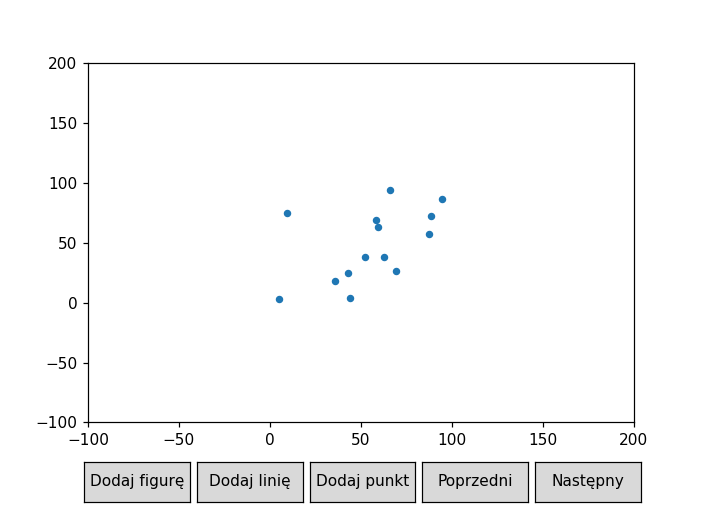

In [35]:
plot = Plot(scenes=scenes_d)
plt.xlim = (-100,200)
plt.ylim = (-100,200)
plot.draw(False)
# plot.draw()

<IPython.core.display.Javascript object>


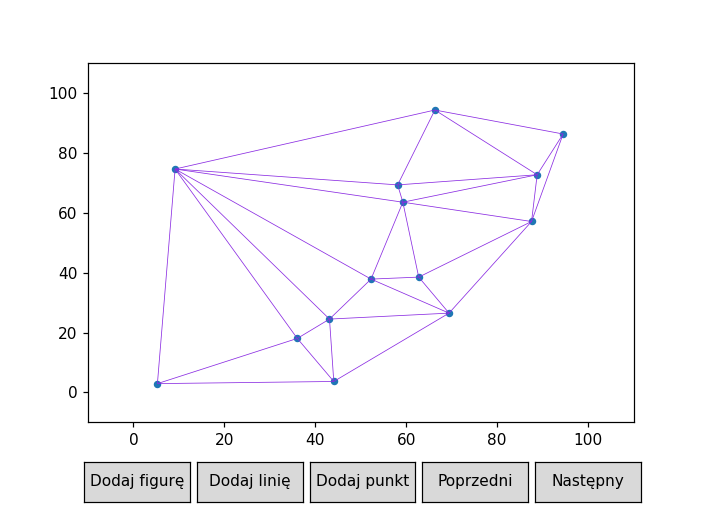

In [36]:
plot = Plot(scenes=scenes_v)
plt.xlim = (-10,110)
plt.ylim = (-10,110)
plot.draw(False)
# plot.draw()

### triangulacja

<IPython.core.display.Javascript object>


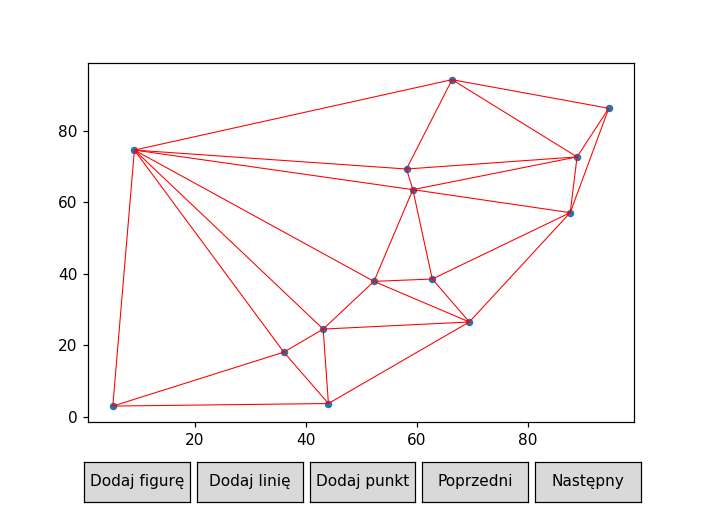

In [37]:
tr,scenes = delaunay(points)
l = triangles_to_lines(tr)

plot = Plot(points = [PointsCollection(points, s=15)],lines = [LinesCollection(l,color = "red", linewidth = 0.7)])
# plt.xlim = (-10,110)
# plt.ylim = (-10,110)
# plot.draw(False)
plot.draw()

### diagram Voronoi

<IPython.core.display.Javascript object>


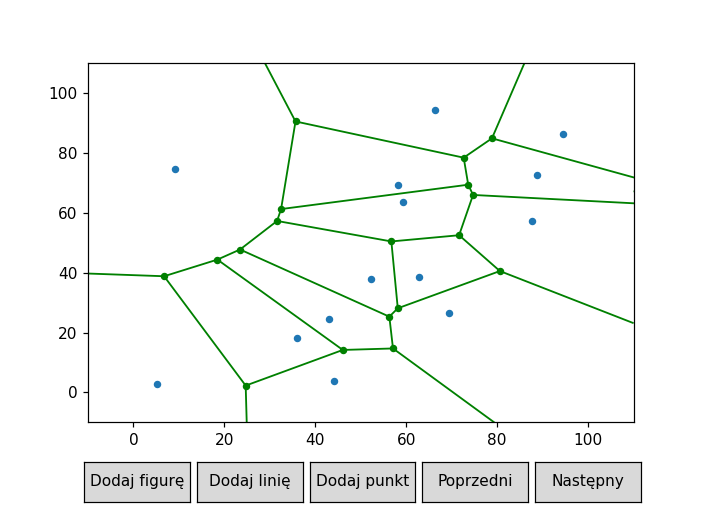

In [38]:
plot = Plot(points = [PointsCollection(points, s=15), PointsCollection(centers, s=15, color = "green")],
            lines = [LinesCollection(vor_edges,color = "green", linewidth = 1.2)])

plt.xlim = (-10,110)
plt.ylim = (-10,110)
plot.draw(False)
# plot.draw()

### triangulacja + diagram Voronoi

<IPython.core.display.Javascript object>


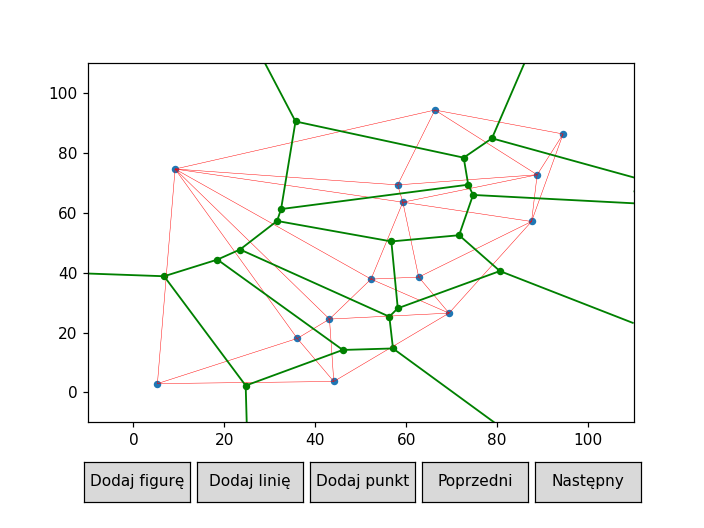

In [39]:
plot = Plot(points = [PointsCollection(points, s=15),
                     PointsCollection(centers, s=15, color = "green")],
            lines = [LinesCollection(l,color = "red", linewidth = 0.3),
                     LinesCollection(vor_edges,color = "green", linewidth = 1.2)
                    ])

plt.xlim = (-10,110)
plt.ylim = (-10,110)
plot.draw(False)
# plot.draw()

## Ex 2

### punkty

<IPython.core.display.Javascript object>


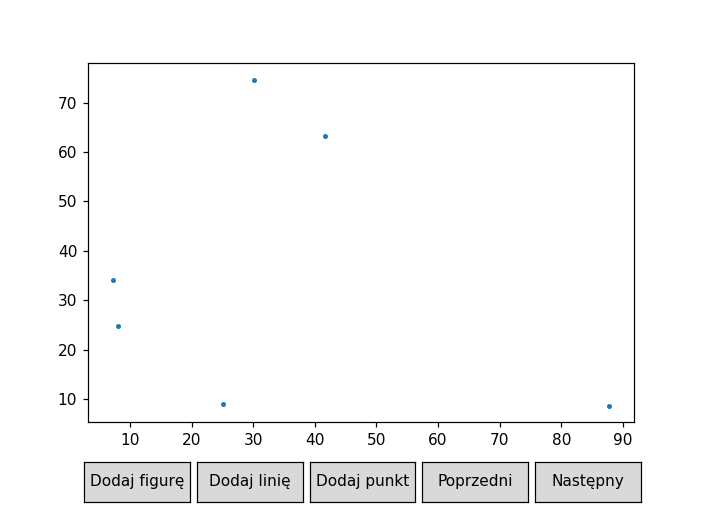

In [42]:
points2 = generate_points(6, [0,100])
plot = Plot(points = [PointsCollection(points2, s=5)])
plot.draw()

In [43]:
centers2,vor_edges2,scenes_d2,scenes_v2 = voronoi_diagram(points2,(-10,-10),(110,110), True)

<IPython.core.display.Javascript object>


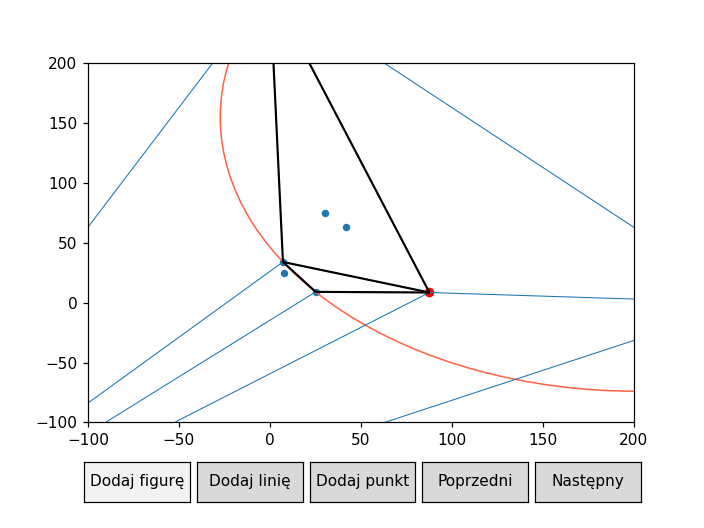

In [44]:
plot2 = Plot(scenes=scenes_d2)
plt.xlim = (-100,200)
plt.ylim = (-100,200)
plot2.draw(False)
# plot.draw()

<IPython.core.display.Javascript object>


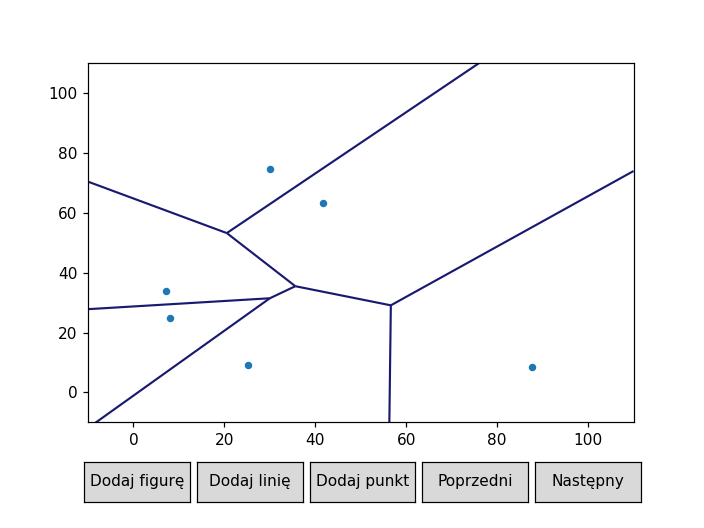

In [45]:
plot2 = Plot(scenes=scenes_v2)
plt.xlim = (-10,110)
plt.ylim = (-10,110)
plot2.draw(False)
# plot.draw()

### triangulacja

In [46]:
tr2,scenes = delaunay(points2)
l2 = triangles_to_lines(tr2)

centers2,vor_edges2,scenes_d,scenes_v = voronoi_diagram(points2,(-10,-10),(110,110), True)

<IPython.core.display.Javascript object>


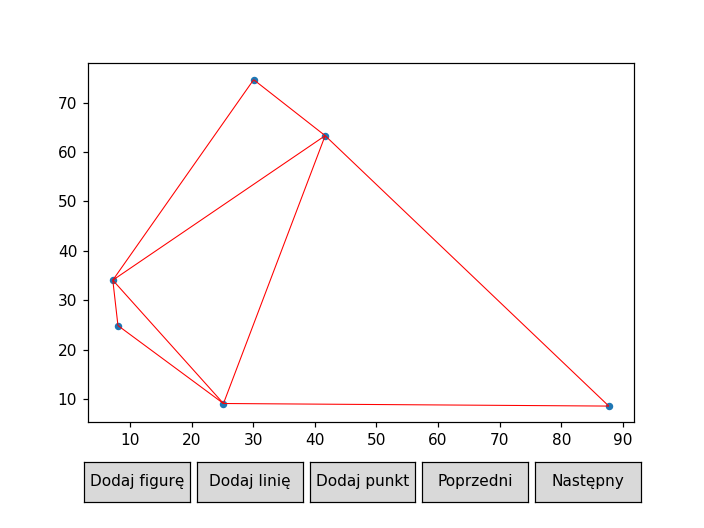

In [47]:
plot = Plot(points = [PointsCollection(points2, s=15)],lines = [LinesCollection(l2,color = "red", linewidth = 0.7)])
# plt.xlim = (-10,110)
# plt.ylim = (-10,110)
# plot.draw(False)
plot.draw()

### diagram Voronoi

<IPython.core.display.Javascript object>


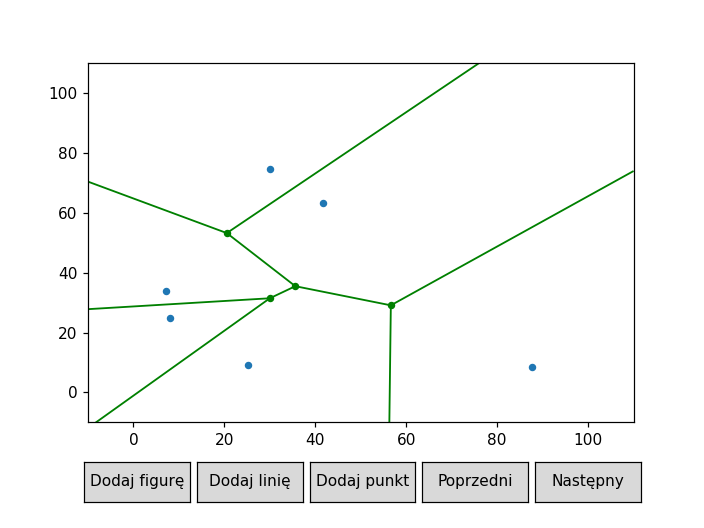

In [48]:
plot = Plot(points = [PointsCollection(points2, s=15), PointsCollection(centers2, s=15, color = "green")],
            lines = [LinesCollection(vor_edges2,color = "green", linewidth = 1.2)])

plt.xlim = (-10,110)
plt.ylim = (-10,110)
plot.draw(False)
# plot.draw()

### triangulacja + diagram Voronoi

<IPython.core.display.Javascript object>


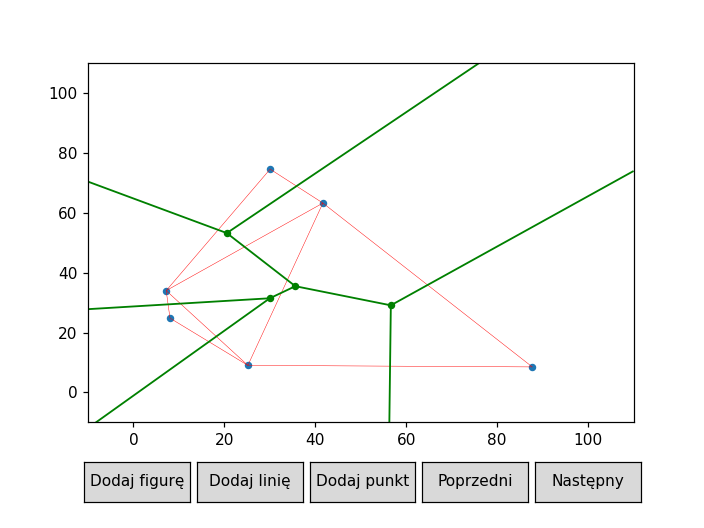

In [49]:
plot = Plot(points = [PointsCollection(points2, s=15), PointsCollection(centers2, s=15, color = "green")],
            lines = [LinesCollection(l2,color = "red", linewidth = 0.3),
                     LinesCollection(vor_edges2,color = "green", linewidth = 1.2)])

plt.xlim = (-10,110)
plt.ylim = (-10,110)
plot.draw(False)
# plot.draw()

### Ex 3

### punkty

<IPython.core.display.Javascript object>


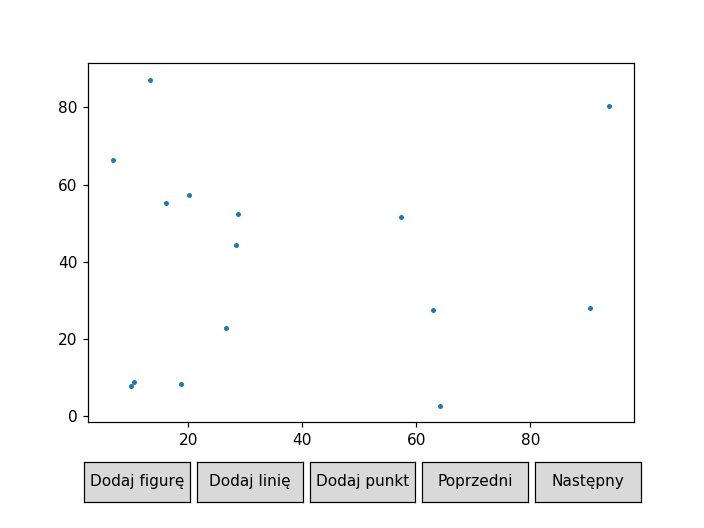

In [50]:
points3 = generate_points(15, [0,100])
plot = Plot(points = [PointsCollection(points3, s=5)])
plot.draw()

### triangulacja

In [51]:
tr3,scenes = delaunay(points3)
l3 = triangles_to_lines(tr3)

centers3,vor_edges3,scenes_d,scenes_v = voronoi_diagram(points3,(-10,-10),(110,110),True)

<IPython.core.display.Javascript object>


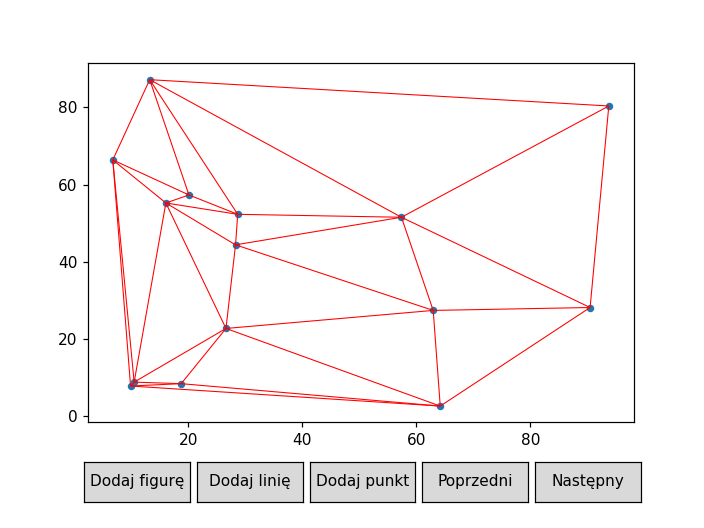

In [52]:
plot = Plot(points = [PointsCollection(points3, s=15)],lines = [LinesCollection(l3,color = "red", linewidth = 0.7)])
# plt.xlim = (-10,110)
# plt.ylim = (-10,110)
# plot.draw(False)
plot.draw()

### diagram Voronoi

<IPython.core.display.Javascript object>


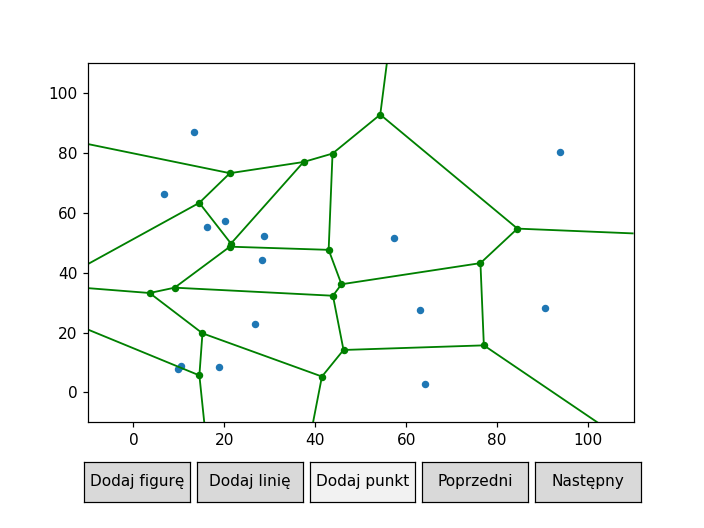

In [53]:
plot = Plot(points = [PointsCollection(points3, s=15), PointsCollection(centers3, s=15, color = "green")],
            lines = [LinesCollection(vor_edges3,color = "green", linewidth = 1.2)])

plt.xlim = (-10,110)
plt.ylim = (-10,110)
plot.draw(False)
# plot.draw()